# Stock Pattern Recognition DL

In [191]:
### import library
import numpy as np
import pandas as pd
from cassandra.cluster import Cluster
from scipy.signal import find_peaks
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight, resample
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical

### 1️⃣ ดึงข้อมูลจาก Cassandra

In [192]:
# --------------------------
# 1) Get data from Cassandra
# --------------------------
def get_candlestick_data(symbol: str, limit: int = 3000,
                         contact_points=['127.0.0.1'], port=9042,
                         keyspace='data_stock'):
    cluster = Cluster(contact_points, port=port)
    session = cluster.connect(keyspace)
    query = f"""
        SELECT time, open_price, high_price, low_price, close_price, volume
        FROM candlestick_data
        WHERE symbol = '{symbol}'
        ORDER BY time DESC
        LIMIT {limit}
    """
    rows = session.execute(query)
    df = pd.DataFrame(rows)
    if df.empty:
        raise ValueError("No rows returned from Cassandra - check query/keyspace/table/symbol.")
    df.columns = df.columns.str.strip().str.lower()
    df.rename(columns={
        'open_price': 'open',
        'high_price': 'high',
        'low_price': 'low',
        'close_price': 'close'
    }, inplace=True)
    df = df.sort_values('time')  # oldest -> newest
    df.set_index('time', inplace=True)
    return df


### 2️⃣ Preprocessing & Feature Engineering

In [193]:
# -------------------------------------
# 2) detect_head_shoulders (simple rule)
# -------------------------------------
def detect_head_shoulders(df, distance=5, tolerance=0.05, debug=False):
    prices = df['close'].values
    peaks, _ = find_peaks(prices, distance=distance)
    troughs, _ = find_peaks(-prices, distance=distance)

    patterns = []

    # H&S
    for i in range(2, len(peaks)):
        l, h, r = peaks[i-2], peaks[i-1], peaks[i]
        left, head, right = prices[l], prices[h], prices[r]
        if head > left and head > right and abs(left - right) / max(head,1e-9) < tolerance:
            neck_left = np.min(prices[l:h]) if h - l > 0 else prices[l]
            neck_right = np.min(prices[h:r]) if r - h > 0 else prices[r]
            neck_slope = (neck_right - neck_left) / max((r - l), 1)
            post_pattern = prices[r:]
            neckline_series = neck_right + neck_slope * np.arange(1, len(post_pattern) + 1)
            below = np.where(post_pattern < neckline_series)[0]
            if below.size > 0:
                break_idx = r + int(below[0])
                patterns.append({
                    'type': 'H&S',
                    'left_idx': int(l),
                    'head_idx': int(h),
                    'right_idx': int(r),
                    'neck_slope': float(neck_slope),
                    'break_idx': int(break_idx)
                })
                if debug:
                    print("H&S:", l, h, r, "break:", break_idx)

    # IH&S
    for i in range(2, len(troughs)):
        l, h, r = troughs[i-2], troughs[i-1], troughs[i]
        left, head, right = prices[l], prices[h], prices[r]
        if head < left and head < right and abs(left - right) / max(abs(head),1e-9) < tolerance:
            neck_left = np.max(prices[l:h]) if h - l > 0 else prices[l]
            neck_right = np.max(prices[h:r]) if r - h > 0 else prices[r]
            neck_slope = (neck_right - neck_left) / max((r - l), 1)
            post_pattern = prices[r:]
            neckline_series = neck_right + neck_slope * np.arange(1, len(post_pattern) + 1)
            above = np.where(post_pattern > neckline_series)[0]
            if above.size > 0:
                break_idx = r + int(above[0])
                patterns.append({
                    'type': 'IH&S',
                    'left_idx': int(l),
                    'head_idx': int(h),
                    'right_idx': int(r),
                    'neck_slope': float(neck_slope),
                    'break_idx': int(break_idx)
                })
                if debug:
                    print("IH&S:", l, h, r, "break:", break_idx)

    return patterns




### 3️⃣ สร้าง Label (H&S / IH&S / None)

In [194]:
# -------------------------------------------------
# 3) Create labels array (0 = none, 1 = H&S, 2 = IH&S)
# -------------------------------------------------
import numpy as np

def create_labels_from_patterns(length, patterns):
    labels = np.zeros(length, dtype=np.int32)
    for p in patterns:
        idx = int(p['head_idx'])
        if 0 <= idx < length:
            if p['type'] == 'H&S':
                labels[idx] = 1
            elif p['type'] == 'IH&S':
                labels[idx] = 2
    return labels



### 4️⃣ สร้าง labels สำหรับ Deep Learning

In [195]:
# ----------------------------------------------------
# 4) Preprocess features and create sequences for LSTM
# ----------------------------------------------------
from sklearn.preprocessing import MinMaxScaler

def compute_rsi(series, period=14):
    # Wilder's RSI using EMA
    delta = series.diff()
    up = delta.clip(lower=0)
    down = -1 * delta.clip(upper=0)
    ma_up = up.ewm(alpha=1/period, adjust=False).mean()
    ma_down = down.ewm(alpha=1/period, adjust=False).mean()
    rs = ma_up / (ma_down + 1e-9)
    rsi = 100 - (100 / (1 + rs))
    return rsi

def compute_macd(series, fast=12, slow=26, signal=9):
    ema_fast = series.ewm(span=fast, adjust=False).mean()
    ema_slow = series.ewm(span=slow, adjust=False).mean()
    macd_line = ema_fast - ema_slow
    signal_line = macd_line.ewm(span=signal, adjust=False).mean()
    macd_hist = macd_line - signal_line
    return macd_line, signal_line, macd_hist

def preprocess_and_create_sequences_with_indicators(
    df,
    labels,
    seq_len=30,
    features_cols=None,
    include_indicators=True,
    rsi_period=14,
    macd_fast=12,
    macd_slow=26,
    macd_signal=9
):
    """
    df: DataFrame with columns ['open','high','low','close','volume']
    labels: array length == len(df)
    returns: X, y, scaler
    """
    df2 = df.copy()

    # --- compute indicators (added columns) ---
    if include_indicators:
        # RSI on close
        df2['rsi'] = compute_rsi(df2['close'], period=rsi_period)

        # MACD
        macd_line, signal_line, macd_hist = compute_macd(df2['close'], fast=macd_fast, slow=macd_slow, signal=macd_signal)
        df2['macd'] = macd_line
        df2['macd_signal'] = signal_line
        df2['macd_hist'] = macd_hist

        # log return
        df2['log_return'] = np.log(df2['close']).diff().fillna(0)

    # default features if not provided
    if features_cols is None:
        # include technical indicators as features
        features_cols = ['open', 'high', 'low', 'close', 'volume', 'rsi', 'macd', 'macd_hist', 'log_return']

    # fill NaNs produced by indicators (at start)
    df_features = df2[features_cols].copy()
    df_features = df_features.fillna(method='ffill').fillna(method='bfill').fillna(0)

    # convert to numpy float32
    data = df_features.values.astype(np.float32)

    # scale
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data)

    # create sequences
    Xs, ys = [], []
    for i in range(len(data_scaled) - seq_len):
        Xs.append(data_scaled[i:i+seq_len])
        ys.append(labels[i+seq_len-1])
    X = np.array(Xs)
    y = np.array(ys, dtype=np.int32)

    return X, y, scaler




### 5️⃣ สร้าง LSTM Model ด้วย Keras

In [196]:
# ----------------------------------------------------
# 5) Preprocess data and create time sequences
# ----------------------------------------------------
from sklearn.preprocessing import MinMaxScaler
import numpy as np

def preprocess_and_create_sequences(df, labels, seq_len=30):
    """
    แปลงข้อมูลแท่งเทียนให้เป็นลำดับ (sequence) สำหรับ LSTM
    - df ต้องมีคอลัมน์ OHLCV: open, high, low, close, volume
    - labels คือ label สำหรับแต่ละ time step (0,1,2)
    """
    feature_cols = ['open', 'high', 'low', 'close', 'volume']
    data = df[feature_cols].values

    # Normalization
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data)

    X, y = [], []
    for i in range(seq_len, len(data_scaled)):
        X.append(data_scaled[i-seq_len:i])
        y.append(labels[i])

    X = np.array(X)
    y = np.array(y)
    return X, y, scaler


### 6️⃣ Train / Validate

In [197]:
# ----------------------------------------------------
# 6) Train pipeline including class weighting / balance
# ----------------------------------------------------

# assume functions imported from previous blocks:
# get_candlestick_data, detect_head_shoulders, create_labels_from_patterns,
# preprocess_and_create_sequences, build_lstm_model

def train_pipeline(symbol='PTT.B', cass_limit=3000, seq_len=30,
                   test_size=0.2, detect_distance=5, detect_tolerance=0.05,
                   use_class_weight=True, oversample=False, epochs=50, batch_size=32):
    # fetch
    df = get_candlestick_data(symbol, limit=cass_limit)
    print("Data length:", len(df))

    # detect
    patterns = detect_head_shoulders(df, distance=detect_distance, tolerance=detect_tolerance, debug=False)
    labels = create_labels_from_patterns(len(df), patterns)
    unique, counts = np.unique(labels, return_counts=True)
    print("Label distribution (0/1/2):", dict(zip(unique, counts)))

    # preprocess
    X, y, scaler = preprocess_and_create_sequences(df, labels, seq_len=seq_len)
    print("X,y shapes:", X.shape, y.shape)
    if X.shape[0] == 0:
        raise ValueError("Not enough data to build sequences. Increase cass_limit or reduce seq_len.")

    # split
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, shuffle=False)
    print("Train/Val shapes:", X_train.shape, X_val.shape)

    # class weight
    cw = None
    if use_class_weight:
        classes = np.unique(y_train)
        weights = class_weight.compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
        cw = {int(c): float(w) for c,w in zip(classes, weights)}
        print("Class weights:", cw)

    # optional oversample
    if oversample:
        train_data = list(zip(X_train, y_train))
        df_train = pd.DataFrame(train_data, columns=['X','y'])
        majority = df_train[df_train['y']==0]
        target_n = max(1, int(len(majority)//2))
        frames = [majority]
        for cls in [1,2]:
            subset = df_train[df_train['y']==cls]
            if len(subset) == 0:
                continue
            up = resample(subset, replace=True, n_samples=target_n, random_state=42)
            frames.append(up)
        df_bal = pd.concat(frames).sample(frac=1, random_state=42)
        X_train = np.stack(df_bal['X'].values)
        y_train = np.array(df_bal['y'].values)
        print("After oversample Train shapes:", X_train.shape, y_train.shape)

    # one-hot
    y_train_cat = to_categorical(y_train, num_classes=3)
    y_val_cat = to_categorical(y_val, num_classes=3)

    # build model
    model = build_lstm_model(seq_len, X.shape[2], n_classes=3)
    model.summary()

    # fit with early stopping
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)]
    history = model.fit(X_train, y_train_cat,
                        validation_data=(X_val, y_val_cat),
                        epochs=epochs, batch_size=batch_size,
                        class_weight=cw,
                        callbacks=callbacks,
                        verbose=2)
    return model, history, (X_train, X_val, y_train, y_val, y_train_cat, y_val_cat), scaler, patterns



In [198]:
# 🔁 เรียก train_pipeline เพื่อสร้าง model และข้อมูลทดสอบ
model, history, (X_train, X_val, y_train, y_val, y_train_cat, y_val_cat), scaler, patterns = train_pipeline(
    symbol='PTT.BK',
    cass_limit=2000,   # ถ้าข้อมูลน้อย ลองลดได้ เช่น 1000
    seq_len=30,
    epochs=5,          # ลด epoch เพื่อเทสต์เร็ว
    batch_size=32
)

print("✅ Model created:", model is not None)
print("✅ Validation data:", X_val.shape, y_val.shape)


Data length: 1400
Label distribution (0/1/2): {np.int32(0): np.int64(1347), np.int32(1): np.int64(28), np.int32(2): np.int64(25)}
X,y shapes: (1370, 30, 5) (1370,)
Train/Val shapes: (1096, 30, 5) (274, 30, 5)
Class weights: {0: 0.3456322926521602, 1: 16.606060606060606, 2: 21.49019607843137}


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_13 (LSTM)                  │ (None, 64)             │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,099 (78.51 KB)

 Trainable params: 20,099 (78.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
35/35 - 2s - 57ms/step - accuracy: 0.8741 - loss: 1.1102 - val_accuracy: 0.9526 - val_loss: 0.9986
Epoch 2/5
35/35 - 0s - 9ms/step - accuracy: 0.7089 - loss: 1.0857 - val_accuracy: 0.9526 - val_loss: 1.0176
Epoch 3/5
35/35 - 0s - 10ms/step - accuracy: 0.5219 - loss: 1.1293 - val_accuracy: 0.0219 - val_loss: 1.1418
Epoch 4/5
35/35 - 0s - 10ms/step - accuracy: 0.3038 - loss: 1.1006 - val_accuracy: 0.9380 - val_loss: 1.0891
Epoch 5/5
35/35 - 0s - 10ms/step - accuracy: 0.1405 - loss: 1.0978 - val_accuracy: 0.0255 - val_loss: 1.1428
✅ Model created: True
✅ Validation data: (274, 30, 5) (274,)


### 7️⃣ ใช้โมเดลทำนาย

Confusion Matrix:
[[261   0   0]
 [  6   0   0]
 [  7   0   0]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9526    1.0000    0.9757       261
           1     0.0000    0.0000    0.0000         6
           2     0.0000    0.0000    0.0000         7

    accuracy                         0.9526       274
   macro avg     0.3175    0.3333    0.3252       274
weighted avg     0.9074    0.9526    0.9294       274



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

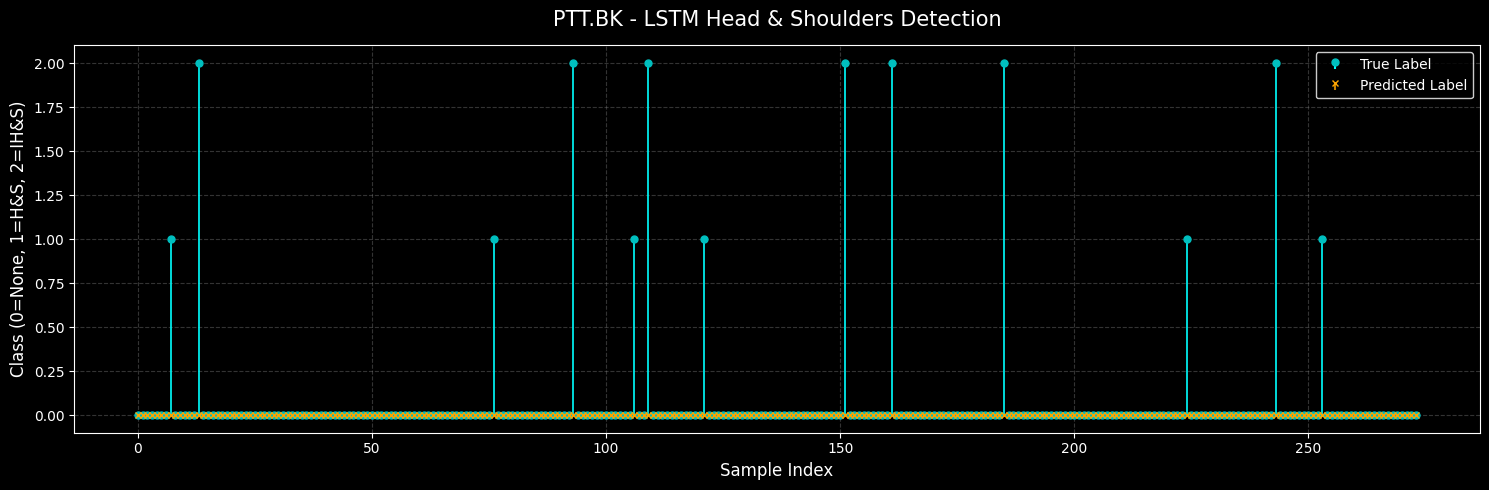

In [199]:
def evaluate_and_plot(model, X_val, y_val, y_val_cat=None, symbol='SYMBOL'):
    # 🔹 Predict
    y_pred = model.predict(X_val, verbose=0)
    y_pred_cls = np.argmax(y_pred, axis=1)
    y_true_cls = y_val

    # 🔹 Metrics
    print("Confusion Matrix:")
    print(confusion_matrix(y_true_cls, y_pred_cls))
    print("\nClassification Report:")
    print(classification_report(y_true_cls, y_pred_cls, digits=4))

    # --- Dark theme plot ---
    plt.style.use('dark_background')
    fig, ax = plt.subplots(figsize=(15, 5), facecolor='black')

    x = np.arange(len(y_true_cls))

    # 🔹 ใช้ stem plot เพื่อให้เห็น discrete points ชัดเจน
    markerline1, stemlines1, baseline1 = ax.stem(x, y_true_cls, linefmt='cyan', markerfmt='co', basefmt=" ", label='True Label')
    markerline2, stemlines2, baseline2 = ax.stem(x, y_pred_cls, linefmt='orange', markerfmt='x', basefmt=" ", label='Predicted Label')

    # ปรับความหนาและความโปร่ง
    plt.setp(stemlines1, linewidth=1.2)
    plt.setp(stemlines2, linewidth=1.2, alpha=0.8)
    plt.setp(markerline1, markersize=5)
    plt.setp(markerline2, markersize=5)

    ax.set_title(f"{symbol} - LSTM Head & Shoulders Detection", color='white', fontsize=15, pad=14)
    ax.set_xlabel("Sample Index", color='white', fontsize=12)
    ax.set_ylabel("Class (0=None, 1=H&S, 2=IH&S)", color='white', fontsize=12)
    ax.grid(True, color='gray', linestyle='--', alpha=0.4)

    legend = ax.legend(facecolor='black', edgecolor='white')
    for text in legend.get_texts():
        text.set_color('white')

    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')

    plt.tight_layout()
    plt.show()
    
evaluate_and_plot(model, X_val, y_val, y_val_cat, symbol='PTT.BK')
